In [1]:
import numpy as np
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cohen_d(group1_mean: float, group2_mean: float, pooled_std: float) -> float:
    """
    Calculates Cohen's d effect size for two group means.
    
    Parameters
    ----------
    group1_mean : float
        Mean of the first group.
    group2_mean : float
        Mean of the second group.
    pooled_sd : float
        Pooled standard deviation of both groups.
        
    Returns
    -------
    float
        Cohen's d effect size.
    """
    if pooled_std <= 0:
        raise ValueError("Pooled standard deviation must be greater than zero.")
    
    return abs(group1_mean - group2_mean) / pooled_std

In [3]:
effect_size = cohen_d(160, 145, 45)
effect_size

0.3333333333333333

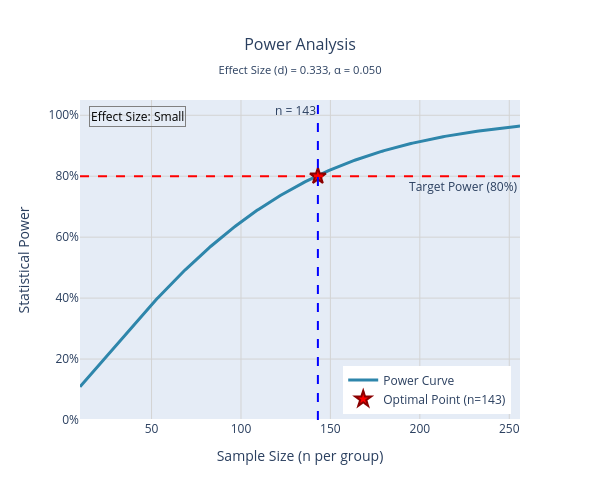

In [7]:
import numpy as np
import plotly.graph_objects as go
from statsmodels.stats.power import TTestIndPower
from typing import Optional, Union

def power_curve(
    effect_size: float, 
    alpha: float = 0.05, 
    power_target: float = 0.80, 
    height: int = 500, 
    width: int = 600, 
    fig_type: Optional[str] = None,
) -> Optional[go.Figure]:
    """
    Generates an interactive Power Analysis plot (Power vs. Sample Size).

    Parameters
    ----------
    effect_size : float
        Cohen's d Effect Size to be detected. Must be positive.
    alpha : float, optional
        Significance level (Type I Error probability). Must be between 0 and 1. Default is 0.05.
    power_target : float, optional
        Target statistical power. Must be between 0 and 1. Default is 0.80.
    max_n : int, optional
        Maximum sample size to plot. If None, automatically calculated as 1.5x required sample size.
    min_n : int, optional
        Minimum sample size to plot. Default is 5.
    height : int, optional
        Plot height in pixels. Default is 500.
    width : int, optional
        Plot width in pixels. Default is 600.
    fig_type : str, optional
        Output format for the plot ('png', 'html', 'svg', etc.). If None, returns Figure object.

    Returns
    -------
    plotly.graph_objects.Figure or None
        Interactive Plotly Figure object if fig_type is None, otherwise None.

    Raises
    ------
    ValueError
        If parameters are outside valid ranges.
    """

    if effect_size <= 0:
        raise ValueError("Effect size must be greater than zero.")
    if not (0 < alpha < 1):
        raise ValueError("Alpha must be between 0 and 1.")
    if not (0 < power_target < 1):
        raise ValueError("Power target must be between 0 and 1.")

    analysis = TTestIndPower()
    n_required = analysis.solve_power(
        effect_size=effect_size,
        alpha=alpha,
        power=power_target,
        ratio=1.0,
        alternative='two-sided'
    )
    
    sample_sizes = np.arange(10, int(n_required * 1.8) + 1, 1)

    powers = analysis.power(
        effect_size=effect_size,
        nobs1=sample_sizes,
        alpha=alpha,
        ratio=1.0,
        alternative='two-sided'
    )

    n_optimal = int(np.ceil(n_required))

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=sample_sizes,
        y=powers,
        mode='lines',
        name='Power Curve',
        line=dict(color='#2E86AB', width=3),
        hovertemplate='<b>Sample Size:</b> %{x}<br><b>Power:</b> %{y:.2%}<extra></extra>'
    ))
    fig.add_hline(
        y=power_target,
        line_dash="dash",
        line_color="red",
        line_width=2,
        annotation_text=f"Target Power ({power_target:.0%})",
        annotation_position="bottom right"
    )
    fig.add_vline(
        x=n_optimal,
        line_dash="dash",
        line_color="blue",
        line_width=2,
        annotation_text=f"n = {n_optimal}",
        annotation_position="top left"
    )
    fig.add_trace(go.Scatter(
        x=[n_optimal],
        y=[power_target],
        mode='markers',
        name=f'Optimal Point (n={n_optimal})',
        marker=dict(
            size=12,
            color='red',
            symbol='star',
            line=dict(width=2, color='darkred')
        ),
        hovertemplate=f'<b>Optimal Sample Size:</b> {n_optimal}<br><b>Target Power:</b> {power_target:.0%}<extra></extra>'
    ))
    fig.update_layout(
        title=dict(
            text=f'Power Analysis<br><sub>Effect Size (d) = {effect_size:.3f}, α = {alpha:.3f}</sub>',
            x=0.5,
            font=dict(size=16)
        ),
        xaxis=dict(
            title='Sample Size (n per group)',
            title_font=dict(size=14),
            tickfont=dict(size=12),
            gridcolor='lightgray'
        ),
        yaxis=dict(
            title='Statistical Power',
            title_font=dict(size=14),
            tickformat=".0%",
            range=[0, 1.05],
            tickfont=dict(size=12),
            gridcolor='lightgray'
        ),
        showlegend=True,
        legend=dict(
            orientation="v",
            yanchor="bottom",
            y=0.02,
            xanchor="right",
            x=0.98
        ),
        hovermode="x unified",
        height=height,
        width=width
    )

    effect_interpretation = ""
    if effect_size < 0.2:
        effect_interpretation = "Very Small"
    elif effect_size < 0.5:
        effect_interpretation = "Small"
    elif effect_size < 0.8:
        effect_interpretation = "Medium"
    else:
        effect_interpretation = "Large"

    fig.add_annotation(
        x=0.02,
        y=0.98,
        xref="paper",
        yref="paper",
        text=f"Effect Size: {effect_interpretation}",
        showarrow=False,
        font=dict(size=12, color="black"),
        bordercolor="gray",
        borderwidth=1
    )

    return fig.show(fig_type)

fig = power_curve(
    effect_size=1/3,
    alpha=0.05,
    power_target=0.80,
    fig_type='png'
)

fig